## 0. Setup

This section imports required libraries and sets display/plotting defaults for reproducible EDA.

**Key libraries:**
- `pandas`, `numpy`: data handling
- `matplotlib`, `seaborn`: visualization
- `sklearn`: clustering (operating regimes), scaling, silhouette score

**Output:** environment ready for analysis.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

sns.set(style='whitegrid')
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", None)

import warnings
warnings.filterwarnings("ignore")

## 1. Load C-MAPSS Training Data (FD001)

Loads the raw `train_FD001.txt` file.

**Note:** C-MAPSS text files contain extra trailing spaces; they often produce empty columns that must be removed.


In [84]:
df_1 = pd.read_csv("CMAPSSData/train_FD001.txt", header=None, sep=" ")
df_1.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [85]:
df_2 = pd.read_csv("CMAPSSData/train_FD002.txt", header=None, sep=" ")
df_3 = pd.read_csv("CMAPSSData/train_FD003.txt", header=None, sep=" ")
df_4 = pd.read_csv("CMAPSSData/train_FD004.txt", header=None, sep=" ")

dfs = [df_1, df_2, df_3, df_4]

In [35]:
offset = 0
fixed = []

for df in dfs:
    d = df.copy()
    d[0] = d[0].astype(int) + offset
    fixed.append(d)
    offset = d[0].iloc[-1]

df = pd.concat(fixed, ignore_index=True)

## 2. Basic Inspection (Shape / Info / Describe)

Quick checks to understand:
- number of rows and columns
- data types and null values
- summary statistics (ranges, mean, quartiles)

**Why this matters:** confirms the dataset is loaded correctly before applying any transformations.


In [36]:
df.shape

(160359, 28)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 28 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       160359 non-null  int64  
 1   1       160359 non-null  int64  
 2   2       160359 non-null  float64
 3   3       160359 non-null  float64
 4   4       160359 non-null  float64
 5   5       160359 non-null  float64
 6   6       160359 non-null  float64
 7   7       160359 non-null  float64
 8   8       160359 non-null  float64
 9   9       160359 non-null  float64
 10  10      160359 non-null  float64
 11  11      160359 non-null  float64
 12  12      160359 non-null  float64
 13  13      160359 non-null  float64
 14  14      160359 non-null  float64
 15  15      160359 non-null  float64
 16  16      160359 non-null  float64
 17  17      160359 non-null  float64
 18  18      160359 non-null  float64
 19  19      160359 non-null  float64
 20  20      160359 non-null  float64
 21  21      16

## 3. Clean Input Format (Drop Extra Columns)

C-MAPSS text files often create 1–2 empty columns due to trailing spaces.
We drop the last two columns to retain the true feature set.

**Output:** correct column count for standard C-MAPSS schema.


In [38]:
df.drop(df.columns[-2:], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       160359 non-null  int64  
 1   1       160359 non-null  int64  
 2   2       160359 non-null  float64
 3   3       160359 non-null  float64
 4   4       160359 non-null  float64
 5   5       160359 non-null  float64
 6   6       160359 non-null  float64
 7   7       160359 non-null  float64
 8   8       160359 non-null  float64
 9   9       160359 non-null  float64
 10  10      160359 non-null  float64
 11  11      160359 non-null  float64
 12  12      160359 non-null  float64
 13  13      160359 non-null  float64
 14  14      160359 non-null  float64
 15  15      160359 non-null  float64
 16  16      160359 non-null  float64
 17  17      160359 non-null  float64
 18  18      160359 non-null  float64
 19  19      160359 non-null  float64
 20  20      160359 non-null  float64
 21  21      16

## 4. Assign Column Names (C-MAPSS Standard)

Maps raw columns to:
- identifiers: `engine_id`, `cycle`
- operating settings: `op_setting_1..3`
- sensors: `sensor_1..sensor_21`

**Output:** a structured dataframe with interpretable feature names.


In [86]:
COLUMNS = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

df_1.drop(df_1.columns[-2:], axis=1, inplace=True)
df_1.columns = COLUMNS
df_2.drop(df_2.columns[-2:], axis=1, inplace=True)
df_2.columns = COLUMNS
df_3.drop(df_3.columns[-2:], axis=1, inplace=True)
df_3.columns = COLUMNS
df_4.drop(df_4.columns[-2:], axis=1, inplace=True)
df_4.columns = COLUMNS

In [39]:
COLUMNS = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

df.columns = COLUMNS
df.head(5)

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [40]:
df.describe()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,370.270050,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,2273.829707,8677.553696,1.153705,44.212049,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,203.411987,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,142.426613,374.657454,0.142103,3.426342,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,1914.720000,7984.510000,0.930000,36.040000,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,196.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,2212.120000,8334.770000,1.020000,42.010000,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,381.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,2319.370000,8764.200000,1.090000,44.930000,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,547.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,2388.050000,9055.850000,1.300000,47.340000,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,709.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,2388.640000,9244.590000,1.320000,48.530000,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


## 5. Data Quality Gate: Schema + Timeline Validations

Validates critical properties needed for time-series / RUL modeling:
- exact expected columns
- missing values overview
- uniqueness of `(engine_id, cycle)`
- cycle values are valid (>= 1)
- per-engine cycles are **monotonic increasing**

**Why this matters:** time-series feature engineering (lags/rolling) and RUL labeling depend on correct ordering.


In [41]:
def schema_checks(df: pd.DataFrame, name: str):
    print(f"=== {name} ===")
    # 1) columns
    assert list(df.columns) == COLUMNS, "Unexpected columns"
    # 2) missing
    miss = df.isna().mean().sort_values(ascending=False)
    print("Missing % (top 5):\n", miss.head())
    # 3) uniqueness
    dup = df.duplicated(["engine_id", "cycle"]).sum()
    print("Duplicate (engine_id,cycle):", dup)
    assert dup == 0, "Duplicates found"
    # 4) non-negative cycle
    assert (df["cycle"] >= 1).all(), "Cycle must be >=1"
    # 5) monotonic cycles per engine
    bad = (df.sort_values(["engine_id","cycle"])
             .groupby("engine_id")["cycle"]
             .apply(lambda s: not s.is_monotonic_increasing)).sum()
    print("Engines with non-monotonic cycles:", bad)
    assert bad == 0, "Non-monotonic cycles detected"

schema_checks(df, "TRAIN")

=== TRAIN ===
Missing % (top 5):
 engine_id    0.0
cycle        0.0
sensor_20    0.0
sensor_19    0.0
sensor_18    0.0
dtype: float64
Duplicate (engine_id,cycle): 0
Engines with non-monotonic cycles: 0


## 6. Fleet Overview: Number of Engines

Counts unique `engine_id` to understand the size of the training fleet.

**Output:** total engines available for training and engine-wise splits.


In [42]:
total_engines = df["engine_id"].nunique()
print(f"Total number of engines: {total_engines}")

Total number of engines: 709


## 7. Fleet Lifecycle Statistics (Cycles to Failure)

Computes lifetime per engine:
- `lifetime(engine) = max(cycle)`

Plots a histogram of engine lifetimes.

**Interpretation:**
- X-axis: cycles until failure
- Y-axis: number of engines in that lifetime range

**Why this matters:** shows variability in lifetimes, which affects model generalization and RUL label distribution.


count    709.000000
mean     226.176305
std       66.434783
min      128.000000
25%      181.000000
50%      207.000000
75%      259.000000
max      543.000000
Name: cycle, dtype: float64


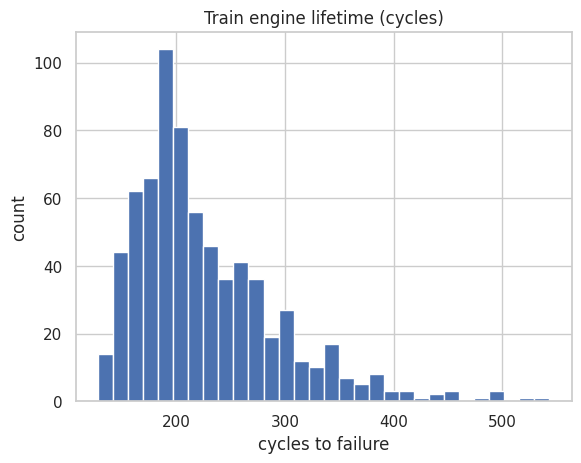

In [43]:
train_life = df.groupby("engine_id")["cycle"].max()

print(train_life.describe())
plt.figure()
plt.hist(train_life, bins=30)
plt.title("Train engine lifetime (cycles)")
plt.xlabel("cycles to failure")
plt.ylabel("count")
plt.show()

## 8. Create Ground-Truth RUL Labels for Training

For training engines, failure point is known (run-to-failure).
RUL at each cycle is computed as:

`RUL = max_cycle(engine) - cycle`

Plots the distribution of uncapped RUL.

**Why this matters:** confirms label generation is correct and shows the natural long-tail of RUL.


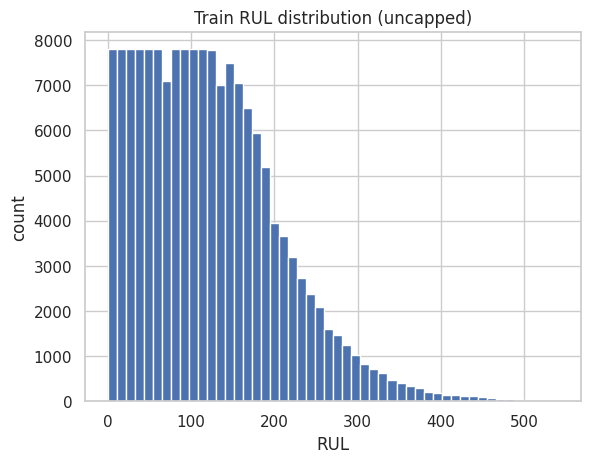

In [44]:
def add_train_rul_labels(df: pd.DataFrame) -> pd.DataFrame:
    max_cycle = df.groupby("engine_id")["cycle"].transform("max")
    df = df.copy()
    df["rul"] = max_cycle - df["cycle"]
    return df

df_rul = add_train_rul_labels(df)

plt.figure()
plt.hist(df_rul["rul"], bins=50)
plt.title("Train RUL distribution (uncapped)")
plt.xlabel("RUL")
plt.ylabel("count")
plt.show()

## 9. Operating Regimes Discovery (Elbow Method)

Operating settings create different regimes (modes of operation).
We scale op settings and run KMeans for multiple `k` values.

**Output:** inertia curve (within-cluster SSE) to identify a reasonable `k`.
**Goal:** choose a small number of regimes that capture operational structure.


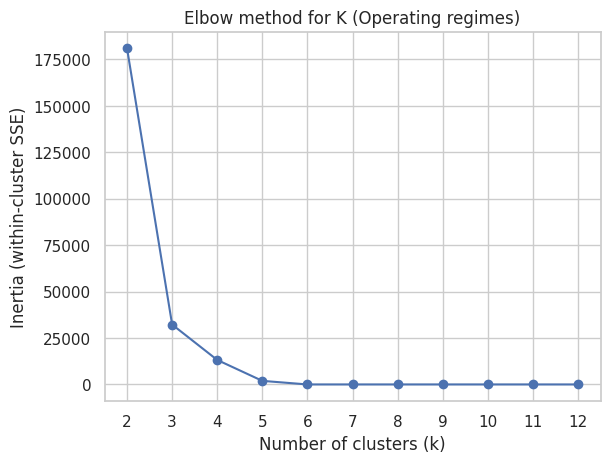

In [116]:
k_values = range(2, 13)
inertias = []

op_cols = [f"op_setting_{i}" for i in range(1,4)]

X = df[op_cols].values
X_scaled = StandardScaler().fit_transform(X)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertias.append(km.inertia_)


plt.figure()
plt.plot(list(k_values), inertias, marker="o")
plt.title("Elbow method for K (Operating regimes)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.xticks(list(k_values))
plt.show()

## 10. Operating Regimes Discovery (Silhouette Score)

Computes silhouette score for each `k` to evaluate cluster separation quality.

**Interpretation:**
- higher silhouette = more distinct clusters
- helps confirm the best `k` beyond just the elbow curve


## 11. Assign Operating Regime Labels

Fits KMeans with chosen `k` and adds `op_regime` labels to each row.

Plots `op_setting_1 vs op_setting_2` colored by `op_regime`.

**Why the plot shows bands:** some operating settings take discrete values, creating stripe-like patterns.
**Why this matters:** sensors can shift by regime → modeling and monitoring must account for regimes.


   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  op_regime
0          1      1       -0.0007       -0.0004         100.0          1
1          1      2        0.0019       -0.0003         100.0          1
2          1      3       -0.0043        0.0003         100.0          1
3          1      4        0.0007        0.0000         100.0          1
4          1      5       -0.0019       -0.0002         100.0          1
5          1      6       -0.0043       -0.0001         100.0          1
6          1      7        0.0010        0.0001         100.0          1
7          1      8       -0.0034        0.0003         100.0          1
8          1      9        0.0008        0.0001         100.0          1
9          1     10       -0.0033        0.0001         100.0          1


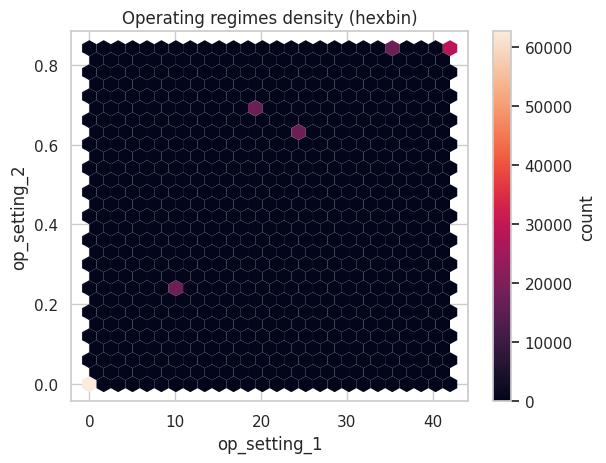

In [117]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_scaled)
df["op_regime"] = kmeans.labels_

cols_to_show = [
    "engine_id",
    "cycle",
    "op_setting_1",
    "op_setting_2",
    "op_setting_3",
    "op_regime",
]

# Show first 10 rows (as currently ordered)
print(df[cols_to_show].head(10))

plt.figure()
plt.hexbin(df["op_setting_1"], df["op_setting_2"], gridsize=25, linewidths=0, edgecolors="none")
plt.title("Operating regimes density (hexbin)")
plt.xlabel("op_setting_1")
plt.ylabel("op_setting_2")
plt.colorbar(label="count")
plt.show()

Why it looks like horizontal bands?

The op_setting_2 takes only a limited set of values (discrete levels), so points align into stripes.
That indicates the dataset has step-like operating modes rather than continuously varying settings.

This is a useful finding:

Operating conditions are not random noise.

They are structured into a few common modes.

 ## 12. Sensor Quality Checks (Industrial Data Reliability)

This section identifies sensors that may be unreliable or uninformative:
1. **Variance:** near-zero variance sensors are effectively constant → candidates to drop.
2. **Missing rate:** sensors with high missingness require imputation or removal.
3. **Unique value count:** very low unique values indicate flat/stuck sensors.

**Output:**
- `low_var_sensors`
- `flat_sensors`
These lists feed directly into feature selection and production validation rules.


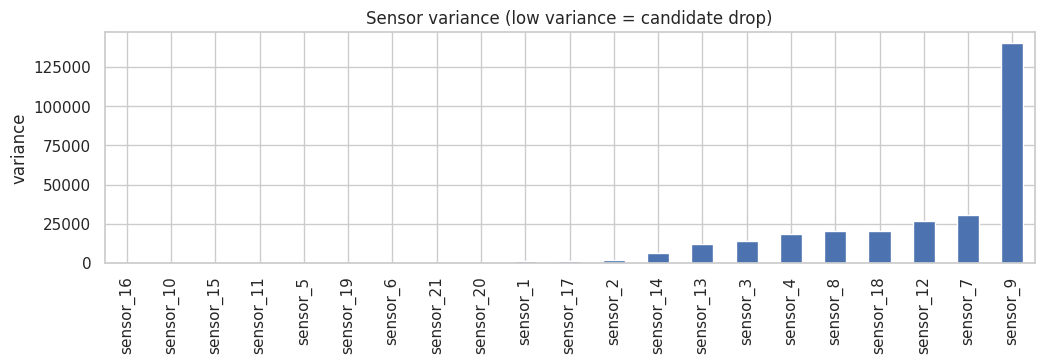

low_var_sensors: []


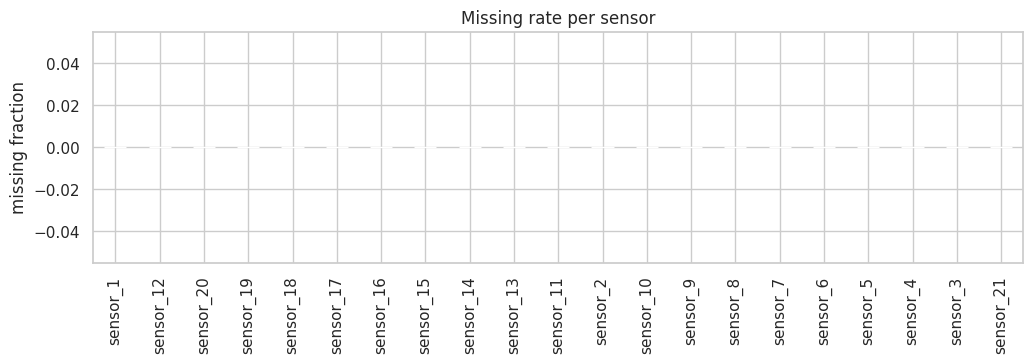

Top 10 missing:
sensor_1     0.0
sensor_12    0.0
sensor_20    0.0
sensor_19    0.0
sensor_18    0.0
dtype: float64


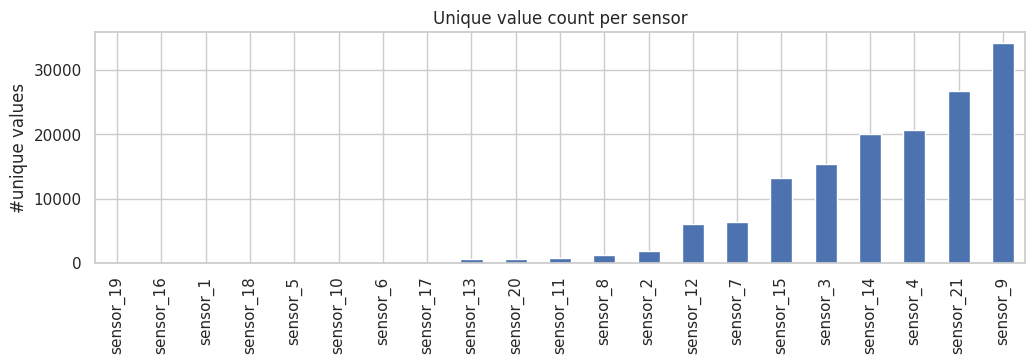

flat_sensors: ['sensor_19', 'sensor_16']


In [47]:
import matplotlib.pyplot as plt

sensor_cols = [f"sensor_{i}" for i in range(1, 22)]

# 1) Variance
var = df[sensor_cols].var().sort_values()
plt.figure(figsize=(12, 3))
var.plot(kind="bar")
plt.title("Sensor variance (low variance = candidate drop)")
plt.ylabel("variance")
plt.show()

low_var_sensors = var[var < 1e-8].index.tolist()
print("low_var_sensors:", low_var_sensors)

# 2) Missing rate
miss = df[sensor_cols].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(12, 3))
miss.plot(kind="bar")
plt.title("Missing rate per sensor")
plt.ylabel("missing fraction")
plt.show()

print("Top 10 missing:")
print(miss.head(5))

# 3) Unique counts
unique_counts = df[sensor_cols].nunique().sort_values()
plt.figure(figsize=(12, 3))
unique_counts.plot(kind="bar")
plt.title("Unique value count per sensor")
plt.ylabel("#unique values")
plt.show()

flat_sensors = unique_counts[unique_counts <= 2].index.tolist()
print("flat_sensors:", flat_sensors)


In [123]:
var["sensor_14"]

np.float64(6500.109570798821)

## 13. Prognostic Sensor Ranking (PHM Metrics)

Ranks sensors based on how useful they are for RUL prediction:

- **Monotonicity:** sensor changes consistently in one direction during degradation
- **Trendability:** |Spearman(sensor, RUL)| averaged across engines
- **Prognosability:** consistency of endpoint behavior across engines (lower variability is better)

A combined weighted score is computed to produce `rank_df`.

**Why this matters:** selects sensors that carry true degradation signal, not noise or operating-condition artifacts.


In [48]:
def monotonicity_per_engine(series: pd.Series) -> float:
    # fraction of consecutive diffs with same sign (trend consistency)
    diffs = np.diff(series.values)
    if len(diffs) == 0:
        return np.nan
    return np.abs((diffs > 0).mean() - (diffs < 0).mean())

def compute_phm_scores(df: pd.DataFrame, sensor: str) -> dict:
    # normalize cycle within each engine to compare shapes
    out = {}
    eng_groups = df.sort_values(["engine_id","cycle"]).groupby("engine_id")

    monos = []
    endpoints = []
    trends = []

    for _, g in eng_groups:
        s = g[sensor].values
        if len(s) < 5:
            continue
        monos.append(monotonicity_per_engine(pd.Series(s)))
        endpoints.append(s[-1] - s[0])
        rho, _ = spearmanr(g[sensor].values, g["rul"].values)
        trends.append(rho)

    out["monotonicity_mean"] = float(np.nanmean(monos))
    out["trendability_mean"] = float(np.nanmean(np.abs(trends)))
    out["prognosability_std_endpoint"] = float(np.nanstd(endpoints))
    return out

scores = []
for s in sensor_cols:
    d = compute_phm_scores(df_rul, s)
    d["sensor"] = s
    scores.append(d)

rank_df = pd.DataFrame(scores)
# Higher monotonicity/trendability is better; lower endpoint std is better
rank_df["score"] = (
    0.45*rank_df["monotonicity_mean"] +
    0.45*rank_df["trendability_mean"] +
    0.10*(1.0/(1.0 + rank_df["prognosability_std_endpoint"]))
)
rank_df = rank_df.sort_values("score", ascending=False).reset_index(drop=True)

rank_df


,monotonicity_mean,trendability_mean,prognosability_std_endpoint,sensor,score
0,0.032494,0.468124,134.471881,sensor_13,0.226016
1,0.033168,0.333421,0.838716,sensor_15,0.219351
2,0.032321,0.356621,3.696646,sensor_11,0.196316
3,0.037636,0.370930,99.696640,sensor_14,0.184848
4,0.032176,0.338449,145.276143,sensor_4,0.167465
5,0.034469,0.307642,177.714963,sensor_12,0.154509
6,0.033262,0.304524,397.260697,sensor_9,0.152255
7,0.036390,0.297681,188.429629,sensor_7,0.150860
8,0.015189,0.125960,0.154556,sensor_10,0.150130
9,0.031114,0.289778,158.492369,sensor_8,0.145029


1) Monotonicity

A sensor is monotonic if it changes consistently in one direction as the engine degrades.

Example: sensor gradually decreases as failure approaches (mostly down, not up-down-up).

Why it matters: monotonic signals are easier for a model to learn and more stable.

In your code, monotonicity is measured per engine by looking at the signs of consecutive differences (diffs) and seeing whether changes are mostly positive or mostly negative.

2) Trendability

A sensor is trendable if it has a strong relationship with degradation across engines.
In the notebook, this is approximated by |Spearman correlation(sensor, RUL)|, averaged over engines.

Spearman is used because it captures monotonic relationships even if not linear.

High |corr| means the sensor tracks “how close to failure” you are.

3) Prognosability

A sensor is prognosable if different engines end in a similar sensor state at failure.
Intuition:

If at failure, sensor ends near the same level for all engines → good failure indicator.

If failure endpoint varies wildly → harder to use for reliable prediction.

In your code, this is approximated using the standard deviation of endpoint change (s[-1] - s[0]) across engines:

Lower std → more consistent degradation endpoint → better prognosability.

## 14. Redundancy Analysis (Correlation)

Computes the sensor correlation matrix to identify sensors providing duplicate information.

- Heatmap visualizes correlation structure.
- Highly correlated pairs (e.g., |corr| > 0.95) are flagged as redundant.

**Decision rule:** from a highly correlated pair, keep the sensor with better PHM score / lower drift / better data quality.


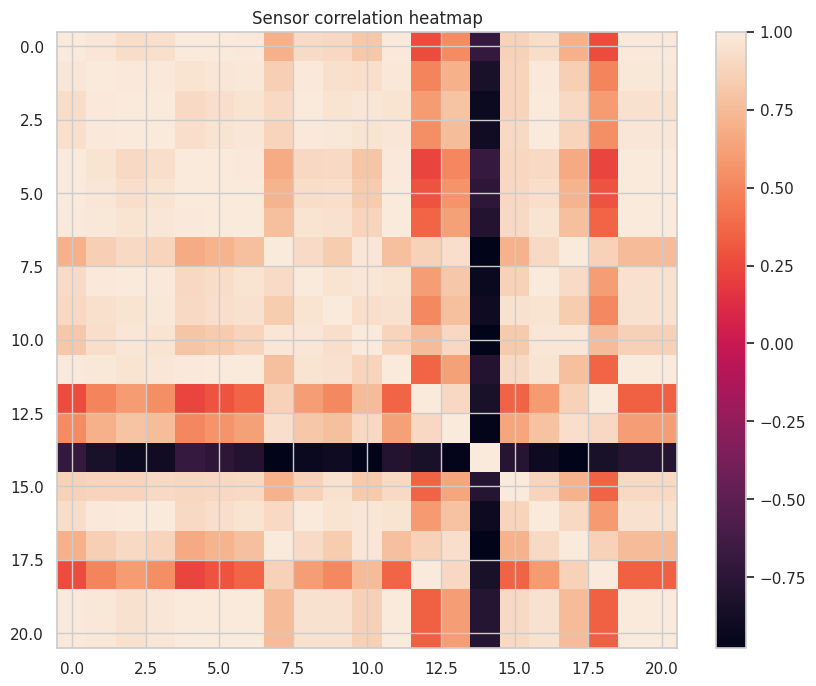

[('sensor_1', 'sensor_2', 0.9694074550571918),
 ('sensor_1', 'sensor_5', 0.9925495941236753),
 ('sensor_1', 'sensor_6', 0.9924467972871948),
 ('sensor_1', 'sensor_7', 0.9853508936224527),
 ('sensor_1', 'sensor_12', 0.985204605115572),
 ('sensor_1', 'sensor_20', 0.9878559613212131),
 ('sensor_1', 'sensor_21', 0.9878641554224156),
 ('sensor_2', 'sensor_3', 0.9891414728111912),
 ('sensor_2', 'sensor_4', 0.9888643398644511),
 ('sensor_2', 'sensor_5', 0.954472111634751)]

In [49]:
corr = df[sensor_cols].corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.title("Sensor correlation heatmap")
plt.colorbar()
plt.show()


high_pairs = []
for i, a in enumerate(sensor_cols):
    for b in sensor_cols[i+1:]:
        if abs(corr.loc[a,b]) > 0.95:
            high_pairs.append((a,b,float(corr.loc[a,b])))
high_pairs[:10]

In [67]:
corr = df[sensor_cols].corr().abs()

pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

print(pairs[pairs >= 0.95])


sensor_8   sensor_18    0.999999
sensor_13  sensor_19    0.999998
sensor_7   sensor_12    0.999995
sensor_20  sensor_21    0.999927
sensor_7   sensor_20    0.999511
           sensor_21    0.999511
sensor_12  sensor_20    0.999479
           sensor_21    0.999479
sensor_3   sensor_17    0.998944
sensor_9   sensor_17    0.998370
sensor_3   sensor_9     0.998325
sensor_5   sensor_6     0.998092
sensor_6   sensor_21    0.998038
           sensor_20    0.998033
           sensor_7     0.996500
           sensor_12    0.996411
sensor_4   sensor_17    0.993885
sensor_3   sensor_4     0.993401
sensor_5   sensor_21    0.992570
           sensor_20    0.992562
sensor_1   sensor_5     0.992550
           sensor_6     0.992447
sensor_4   sensor_9     0.991848
sensor_2   sensor_17    0.989728
sensor_5   sensor_7     0.989562
           sensor_12    0.989408
sensor_2   sensor_3     0.989141
           sensor_4     0.988864
sensor_1   sensor_21    0.987864
           sensor_20    0.987856
sensor_2  

If abs(corr) > 0.95, drop the sensor with:

lower PHM score, or

higher drift score (PSI), or

more missing values / lower variance.

## 15. Train vs Test Drift Check (PSI) — Monitoring Plan

Uses Population Stability Index (PSI) to quantify distribution shift between:
- training sensor distributions (baseline)
- test sensor distributions (proxy for “future / production” data)

**Why this matters for MLOps:**
- identifies which sensors are likely to drift
- defines what to monitor in production
- provides a trigger signal for retraining/investigation


In [24]:
def psi(expected: np.ndarray, actual: np.ndarray, bins=10) -> float:
    # Population Stability Index
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]
    breakpoints = np.quantile(expected, np.linspace(0,1,bins+1))
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    e_perc = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    a_perc = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    e_perc = np.clip(e_perc, 1e-6, None)
    a_perc = np.clip(a_perc, 1e-6, None)

    return float(np.sum((e_perc - a_perc) * np.log(e_perc / a_perc)))

test_df = pd.read_csv("CMAPSSData/test_FD001.txt", header=None, sep=" ")
test_df.drop(test_df.columns[-2:], axis=1, inplace=True)
test_df.columns = COLUMNS

drift_rows = []
for s in sensor_cols:
    drift_rows.append({
        "sensor": s,
        "psi_train_vs_test": psi(df[s].values, test_df[s].values, bins=10)
    })

drift_df = pd.DataFrame(drift_rows).sort_values("psi_train_vs_test", ascending=False).reset_index(drop=True)
drift_df

,sensor,psi_train_vs_test
0,sensor_6,8.759418
1,sensor_10,7.881056
2,sensor_1,7.725323
3,sensor_18,7.725323
4,sensor_5,7.725323
5,sensor_12,7.711628
6,sensor_7,7.678721
7,sensor_15,7.678020
8,sensor_21,7.605241
9,sensor_20,7.596309


PSI = Population Stability Index.
It’s a single number that measures how different two distributions are (expected vs actual).

PSI near 0 → distributions are similar (stable).

Higher PSI → distribution shift (drift).

Typical interpretation (rule-of-thumb):

< 0.1: no meaningful drift

0.1–0.2: moderate drift (watch)

\> 0.2: significant drift (investigate/monitor/retrain)

## 16. cap_RUL Selection (Early-life Saturation)

Goal: choose `rul_cap` where sensors begin to show meaningful degradation signal.

Approach:
- Split training data into RUL bands (0–30, 30–60, …).
- For top prognostic sensors, compute |Spearman(sensor, RUL)| inside each band.
- Plot mean correlation per band.

**Interpretation:**
- High correlation at low RUL = sensors strongly reflect degradation near failure.
- Very low correlation at high RUL = early-life region is hard to distinguish (saturated).
- Choose `rul_cap` near the transition (“elbow”) where correlation starts rising.


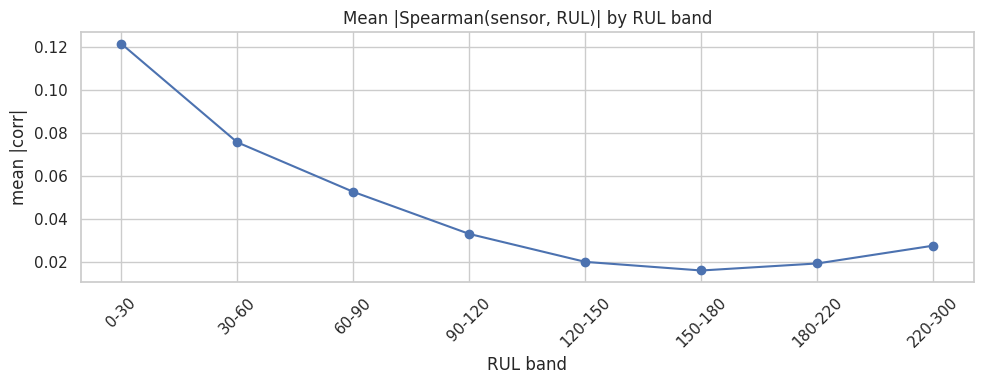

,band,sensor,spearman_abs
0,0-30,sensor_13,0.135981
1,0-30,sensor_15,0.075813
2,0-30,sensor_11,0.172121
3,0-30,sensor_14,0.069278
4,0-30,sensor_4,0.154940
5,30-60,sensor_13,0.130014
6,30-60,sensor_15,0.039442
7,30-60,sensor_11,0.086277
8,30-60,sensor_14,0.044198
9,30-60,sensor_4,0.078782


In [71]:
TOP_SENSORS = rank_df.head(5)["sensor"].tolist()


bands = [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 220), (220, 300)]

rows = []
for lo, hi in bands:
    sub = df_rul[(df_rul["rul"] >= lo) & (df_rul["rul"] < hi)]
    for s in TOP_SENSORS:
        rho, _ = spearmanr(sub[s].values, sub["rul"].values)
        rows.append({"band": f"{lo}-{hi}", "sensor": s, "spearman_abs": float(abs(rho))})

band_corr = pd.DataFrame(rows)

band_order = [f"{lo}-{hi}" for lo, hi in bands]

mean_band = (
    band_corr.groupby("band")["spearman_abs"].mean()
    .reindex(band_order)                 
    .reset_index()
)

plt.figure(figsize=(10,4))
plt.plot(mean_band["band"], mean_band["spearman_abs"], marker="o")
plt.xticks(rotation=45)
plt.title("Mean |Spearman(sensor, RUL)| by RUL band")
plt.xlabel("RUL band")
plt.ylabel("mean |corr|")
plt.tight_layout()
plt.show()

band_corr.head(10)

## 17. Apply `rul_cap` and Compare Label Distributions

Creates `rul_cap = min(rul, cap)` and plots:
- uncapped RUL distribution
- capped RUL distribution

**Why distributions differ:** all values above cap collapse into a spike at the cap value.
**Why this matters:** capping stabilizes training and focuses the model on informative degradation region.


In [72]:
def apply_rul_cap(df: pd.DataFrame, rul_cap: int | None) -> pd.DataFrame:
    df = df.copy()
    if rul_cap is None:
        df["rul_cap"] = df["rul"]
    else:
        df["rul_cap"] = df["rul"].clip(upper=rul_cap)
    return df


rul_cap_value = 135
df = apply_rul_cap(df_rul, rul_cap=rul_cap_value)

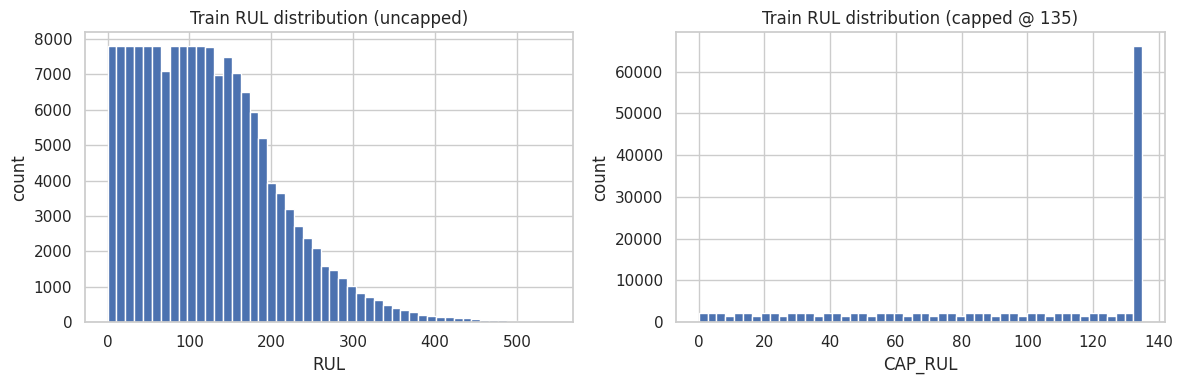

In [73]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(df["rul"], bins=50)
plt.title("Train RUL distribution (uncapped)")
plt.xlabel("RUL")
plt.ylabel("count")

plt.subplot(1,2,2)
plt.hist(df["rul_cap"], bins=50)
plt.title(f"Train RUL distribution (capped @ {rul_cap_value})")
plt.xlabel("CAP_RUL")
plt.ylabel("count")

plt.tight_layout()
plt.show()

## 18. Cycle Continuity Check (No Missing Time Steps)

Even if cycles are monotonic, gaps like 1,2,3,5 can break lag/rolling features.
This cell checks whether cycles increment by 1 for each engine.


In [74]:
def cycle_continuity_report(df: pd.DataFrame, name: str):
    df2 = df.sort_values(["engine_id","cycle"]).copy()
    df2["cycle_diff"] = df2.groupby("engine_id")["cycle"].diff()

    # diffs should be 1 (except first row per engine which is NaN)
    gaps = df2[(df2["cycle_diff"].notna()) & (df2["cycle_diff"] != 1)]
    print(f"=== {name} Cycle Continuity ===")
    print("Total gap rows:", len(gaps))
    if len(gaps) > 0:
        print("Sample gaps:\n", gaps[["engine_id","cycle","cycle_diff"]].head(10))
        print("Engines with gaps:", gaps["engine_id"].nunique())
    return gaps

train_gaps = cycle_continuity_report(df, "TRAIN")

=== TRAIN Cycle Continuity ===
Total gap rows: 0


## 19. Sensor Trajectories (Degradation Visual Evidence)

We plot top-ranked sensors across multiple engines to visually confirm:
- stable degradation trends
- regime effects
- noise/outliers


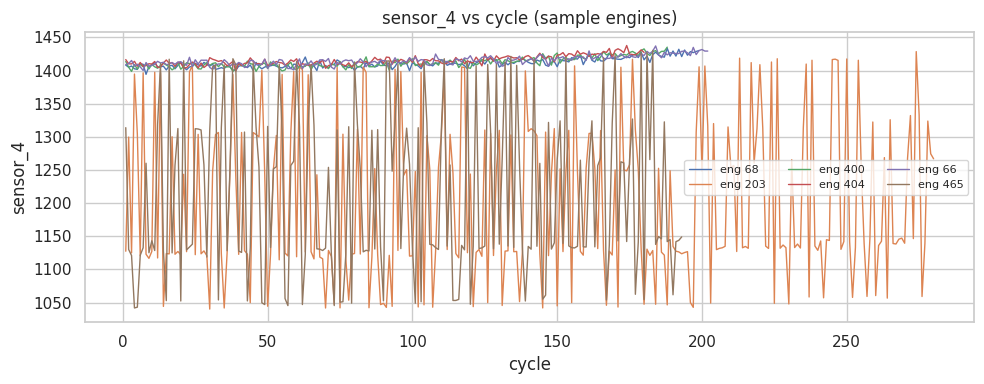

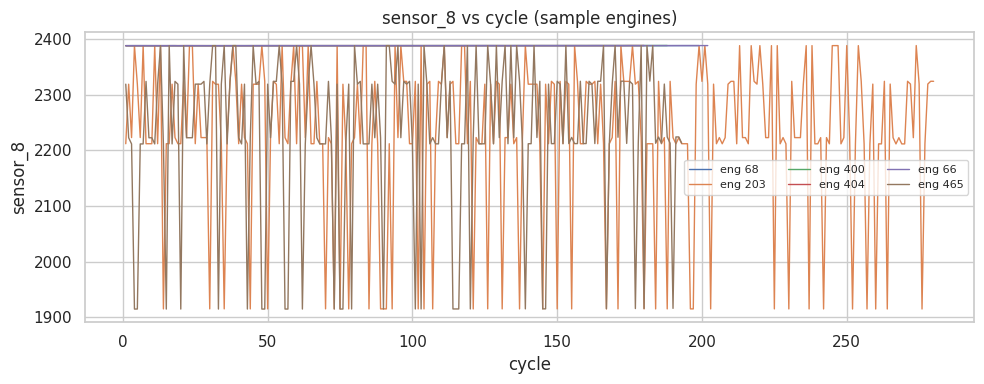

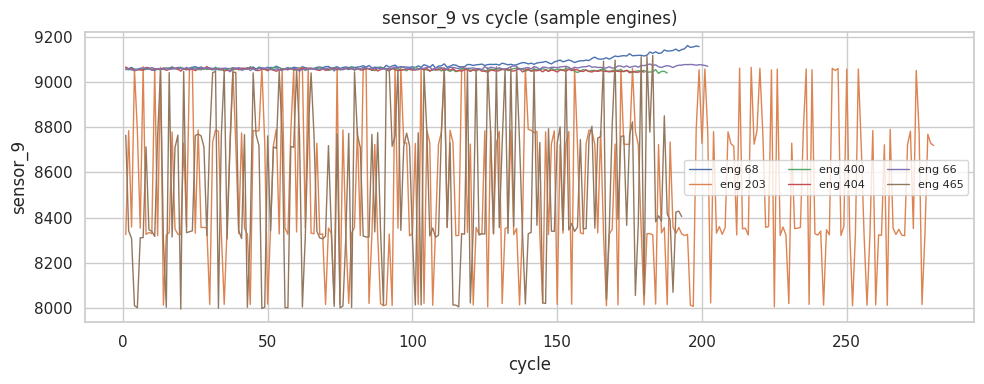

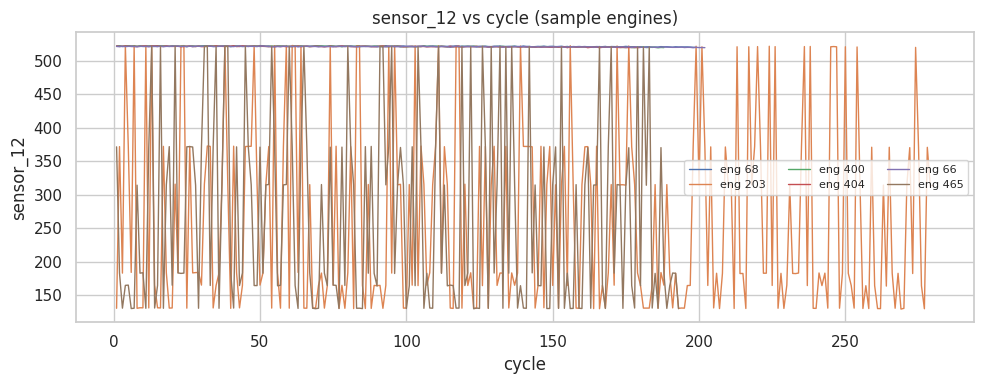

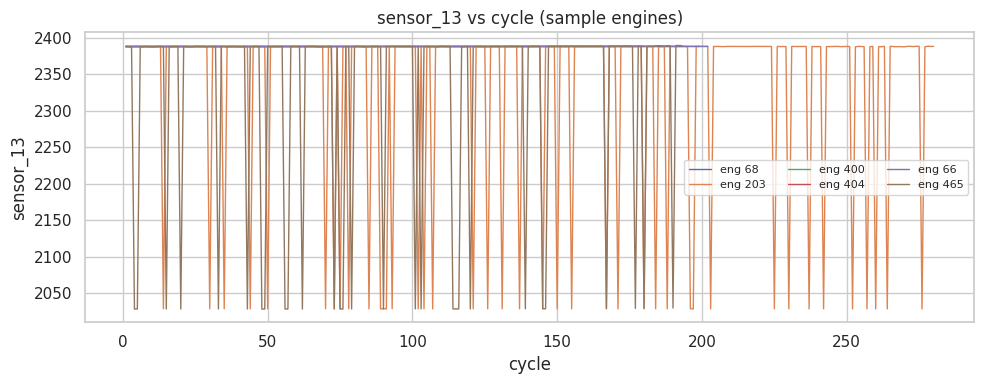

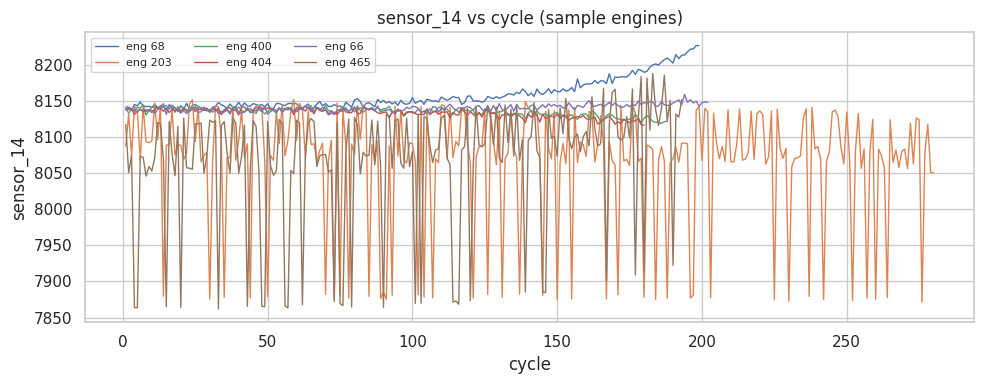

In [75]:
top_sensors = ["sensor_4","sensor_8","sensor_9","sensor_12", "sensor_13", "sensor_14"]

# Sample engines
sample_engines = np.random.choice(df["engine_id"].unique(), size=6, replace=False)

for s in top_sensors:
    plt.figure(figsize=(10,4))
    for eid in sample_engines:
        g = df[df["engine_id"] == eid].sort_values("cycle")
        plt.plot(g["cycle"], g[s], label=f"eng {eid}", linewidth=1)
    plt.title(f"{s} vs cycle (sample engines)")
    plt.xlabel("cycle")
    plt.ylabel(s)
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()


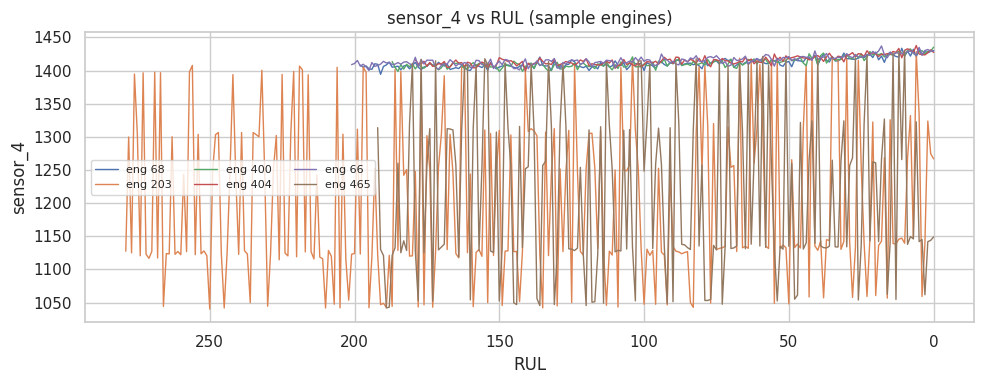

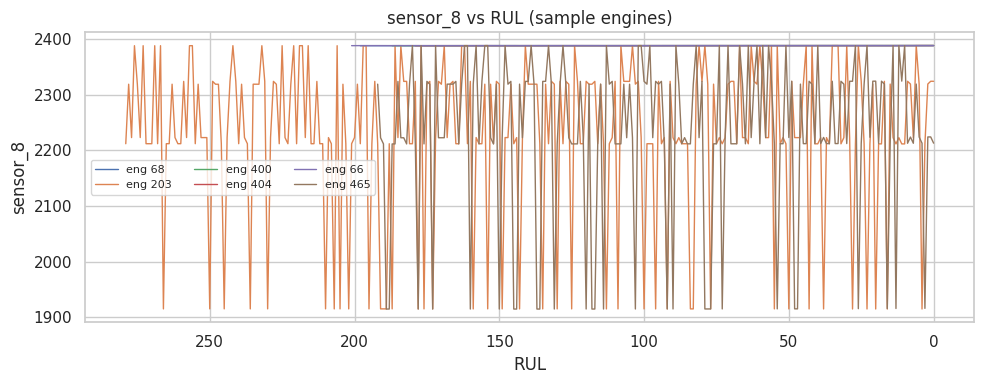

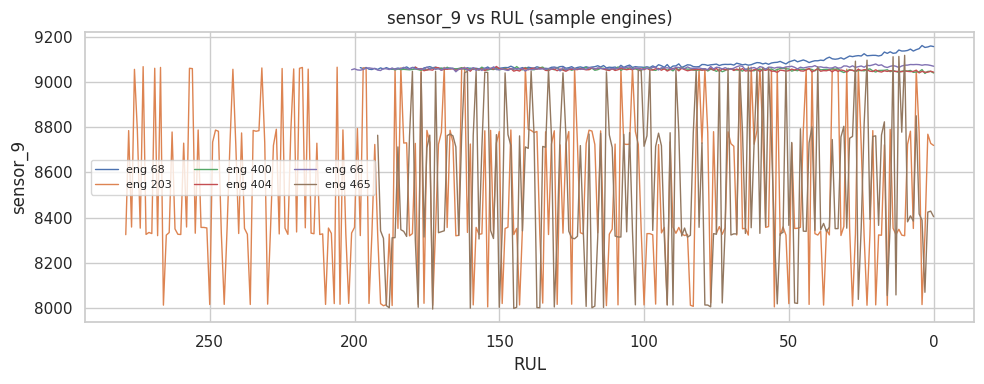

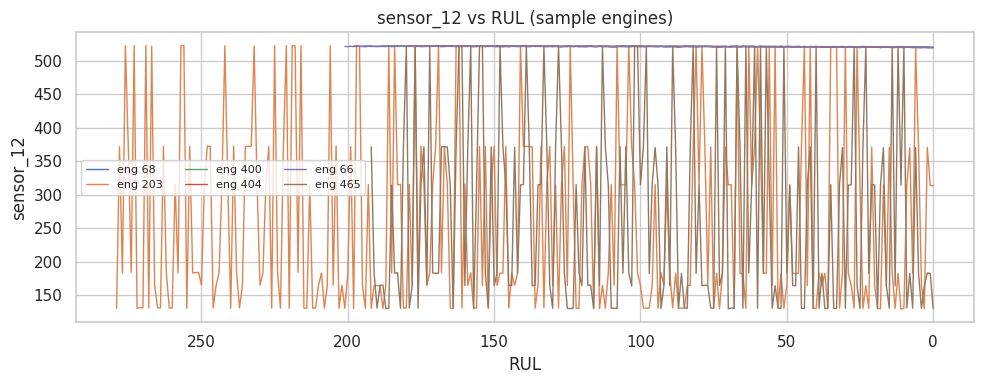

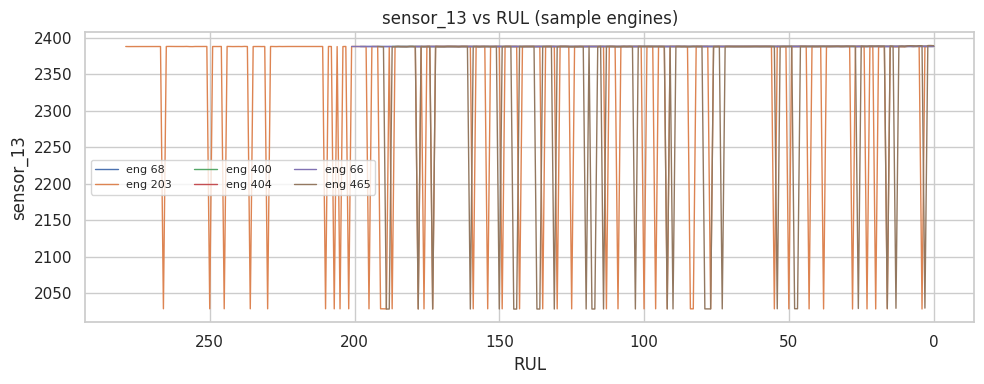

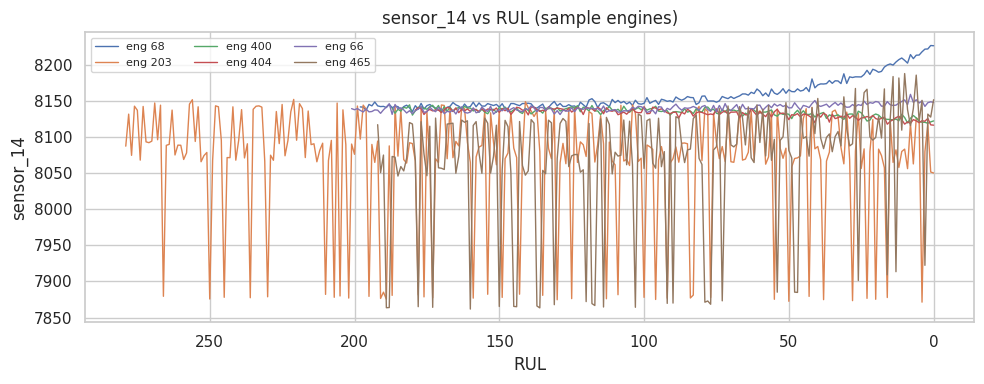

In [76]:
for s in top_sensors:
    plt.figure(figsize=(10,4))
    for eid in sample_engines:
        g = df[df["engine_id"] == eid].sort_values("cycle")
        plt.plot(g["rul"], g[s], label=f"eng {eid}", linewidth=1)
    plt.title(f"{s} vs RUL (sample engines)")
    plt.xlabel("RUL")
    plt.ylabel(s)
    plt.gca().invert_xaxis()
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()


## Outlier Check 1 (Univariate): IQR Rule per Sensor

This detects extreme values per sensor using the Interquartile Range (IQR).
It reports the fraction of rows considered outliers for each sensor.

Why it matters:
- high outlier rate can indicate sensor faults, spikes, or regime effects
- informs preprocessing: robust scaling, clipping, or winsorization


In [101]:
sensor_cols = [f"sensor_{i}" for i in range(1,22)]

def iqr_outlier_fraction(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = df[c].dropna()
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0:
            rows.append({"col": c, "iqr": float(iqr), "outlier_frac": 0.0})
            continue
        lo = q1 - 1.5 * iqr
        hi = q3 + 1.5 * iqr
        frac = ((df[c] < lo) | (df[c] > hi)).mean()
        rows.append({"col": c, "iqr": float(iqr), "outlier_frac": float(frac), "lo": float(lo), "hi": float(hi)})
    return pd.DataFrame(rows).sort_values("outlier_frac", ascending=False)

iqr_report = iqr_outlier_fraction(df, sensor_cols)
iqr_report.head(10)


,col,iqr,outlier_frac,lo,hi
12,sensor_13,0.19000,0.160858,2387.685000,2388.445000
13,sensor_14,68.88000,0.107715,7967.210000,8242.730000
17,sensor_18,176.00000,0.106891,1948.000000,2652.000000
7,sensor_8,175.93000,0.106891,1948.225000,2651.945000
14,sensor_15,0.90495,0.105083,7.081825,10.701625
0,sensor_1,69.23000,0.000000,345.595000,622.515000
11,sensor_12,356.55000,0.000000,-370.035000,1056.165000
19,sensor_20,24.49000,0.000000,-22.405000,75.555000
18,sensor_19,0.00000,0.000000,NaN,NaN
16,sensor_17,60.00000,0.000000,242.000000,482.000000


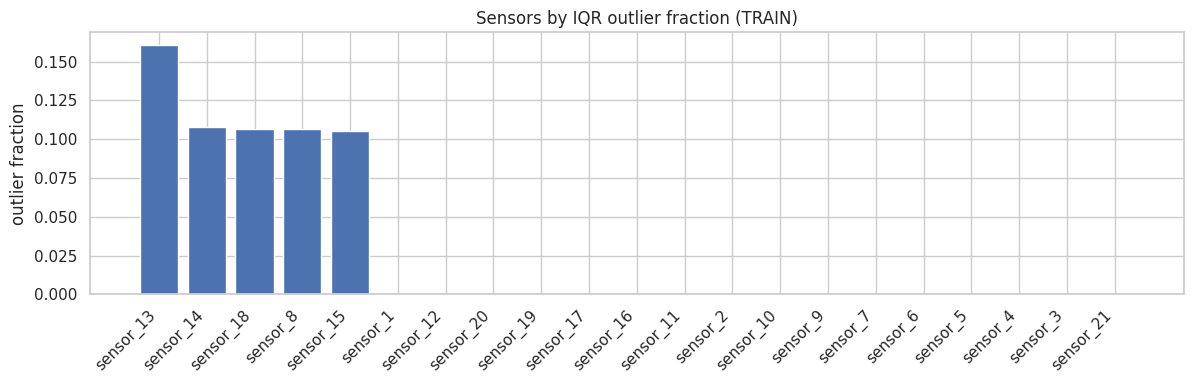

In [105]:
plt.figure(figsize=(12,4))
plt.bar(iqr_report["col"], iqr_report["outlier_frac"])
plt.title("Sensors by IQR outlier fraction (TRAIN)")
plt.ylabel("outlier fraction")

plt.xticks(rotation=45, ha="right") 
plt.tight_layout()                  

plt.show()

## Outlier Check 2 (Univariate): Robust Z-score using MAD

This flags outliers based on Median Absolute Deviation (MAD), which is robust to extreme values.
Rule: |robust_z| > 3.5 (common industrial threshold).

In [120]:
def robust_z_outlier_fraction(df: pd.DataFrame, cols: list[str], thresh=3.5) -> pd.DataFrame:
    rows = []
    for c in cols:
        x = df[c].dropna().values
        med = np.median(x)
        mad = np.median(np.abs(x - med))
        if mad == 0:
            rows.append({"col": c, "mad": float(mad), "outlier_frac": 0.0})
            continue
        robust_z = 0.6745 * (df[c] - med) / mad
        frac = (robust_z.abs() > thresh).mean()
        rows.append({"col": c, "mad": float(mad), "outlier_frac": float(frac)})
    return pd.DataFrame(rows).sort_values("outlier_frac", ascending=False)

mad_report = robust_z_outlier_fraction(df, sensor_cols, thresh=3.5)
mad_report.head(10)


,col,mad,outlier_frac
12,sensor_13,0.09,0.141445
17,sensor_18,69.00,0.106891
7,sensor_8,68.77,0.106891
13,sensor_14,31.04,0.106842
0,sensor_1,29.62,0.000000
11,sensor_12,190.99,0.000000
19,sensor_20,13.78,0.000000
18,sensor_19,0.00,0.000000
16,sensor_17,27.00,0.000000
15,sensor_16,0.00,0.000000


## Outlier Check 3 (Multivariate): Isolation Forest

Detects anomalies based on unusual combinations across multiple sensors/features.
This is closer to how industrial anomaly detection works.

Output:
- anomaly score per row
- top anomalous rows
- anomaly rate (based on chosen contamination)


In [121]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

feature_cols = [f"op_setting_{i}" for i in range(1,4)] + sensor_cols

X = df[feature_cols].copy()

# Fill missing if any (C-MAPSS usually has none, but keep safe)
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,  # 1% anomalies (adjust 0.005–0.02)
    random_state=42,
    n_jobs=-1
)
labels = iso.fit_predict(X_scaled)  # -1 = anomaly, +1 = normal
scores = iso.decision_function(X_scaled)  # lower = more anomalous

df["iso_anomaly"] = (labels == -1).astype(int)
df["iso_score"] = scores

print("IsolationForest anomaly fraction:", df["iso_anomaly"].mean())

# Show most anomalous samples
df.sort_values("iso_score").head(20)[["engine_id","cycle","iso_anomaly","iso_score"]]

IsolationForest anomaly fraction: 0.01000255676326243


,engine_id,cycle,iso_anomaly,iso_score
109749,503,222,1,-0.052022
146504,650,376,1,-0.050539
102545,472,271,1,-0.049902
111147,508,321,1,-0.049570
112711,513,303,1,-0.049123
145633,647,271,1,-0.048050
131950,593,485,1,-0.048013
136747,614,202,1,-0.047372
131948,593,483,1,-0.047277
145196,645,256,1,-0.045319


## Regime-aware Outliers (Recommended)

Because operating conditions shift sensor distributions, detect outliers **within each op_regime**.
This reduces false positives caused by regime changes.


In [119]:
assert "op_regime" in df.columns, "Compute op_regime first (KMeans) before regime-aware outliers."

def iqr_outliers_by_regime(df: pd.DataFrame, cols: list[str], regime_col="op_regime") -> pd.DataFrame:
    rows = []
    for r, g in df.groupby(regime_col):
        for c in cols:
            s = g[c].dropna()
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            if iqr == 0:
                continue
            lo = q1 - 1.5 * iqr
            hi = q3 + 1.5 * iqr
            frac = ((g[c] < lo) | (g[c] > hi)).mean()
            rows.append({"op_regime": int(r), "col": c, "outlier_frac": float(frac)})
    return pd.DataFrame(rows).sort_values("outlier_frac", ascending=False)

reg_iqr_report = iqr_outliers_by_regime(df, sensor_cols)
reg_iqr_report


,op_regime,col,outlier_frac
24,1,sensor_12,0.282516
20,1,sensor_7,0.276425
22,1,sensor_9,0.258664
21,1,sensor_8,0.239478
19,1,sensor_6,0.217640
29,1,sensor_20,0.217415
30,1,sensor_21,0.217290
16,1,sensor_2,0.216915
17,1,sensor_3,0.216902
18,1,sensor_4,0.216790
